In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook 
from hmmlearn import hmm
import seaborn as sns
from sklearn.metrics import mean_squared_error

regimes = 4

In [2]:
### API
binance_api_key = '25HUOrJu76evPWNCJtSDydExaKtdB6DjyItVW5lTYSzEe2NgAvMsfLfuuX8Ake1m'  
binance_api_secret = 'vBaUNet4o7N2qVA3lW84Is6RXFnAt4Q6Dk6qdfiR1VzAOi0vO4Ujq2eCq0qHjCfP'

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

def get_return(pre, post):
    return (post-pre)/pre

In [81]:
data = get_all_binance("ETHUSDT", "5m", save = True)

All caught up..!


In [4]:
close = data.iloc[:,3].astype(float)

In [24]:
obs = []
temp = []
values = []
for i in range(0, len(close)):
    temp.append(close[i])
    if len(temp) == 288:
        today = [get_return(temp[0], temp[-1]), mean_squared_error(temp, [sum(temp) / len(temp)] * len(temp))]
        values.append(temp[-1])
        obs.append(today)
        temp = []

training = obs[300:900]
test = obs[900:1100]

In [6]:
# Creating the Hidden Markov Model
model = hmm.GaussianHMM(n_components = regimes, covariance_type="full", n_iter = 75);

# Fitting the model and obtaining predictions
model.fit(obs)
predictions = model.predict(obs)

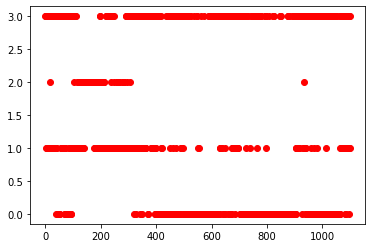

In [7]:
plt.plot(predictions, 'ro');

In [8]:
df = pd.DataFrame(data=values)
df = df.rename(columns={0: "values"})

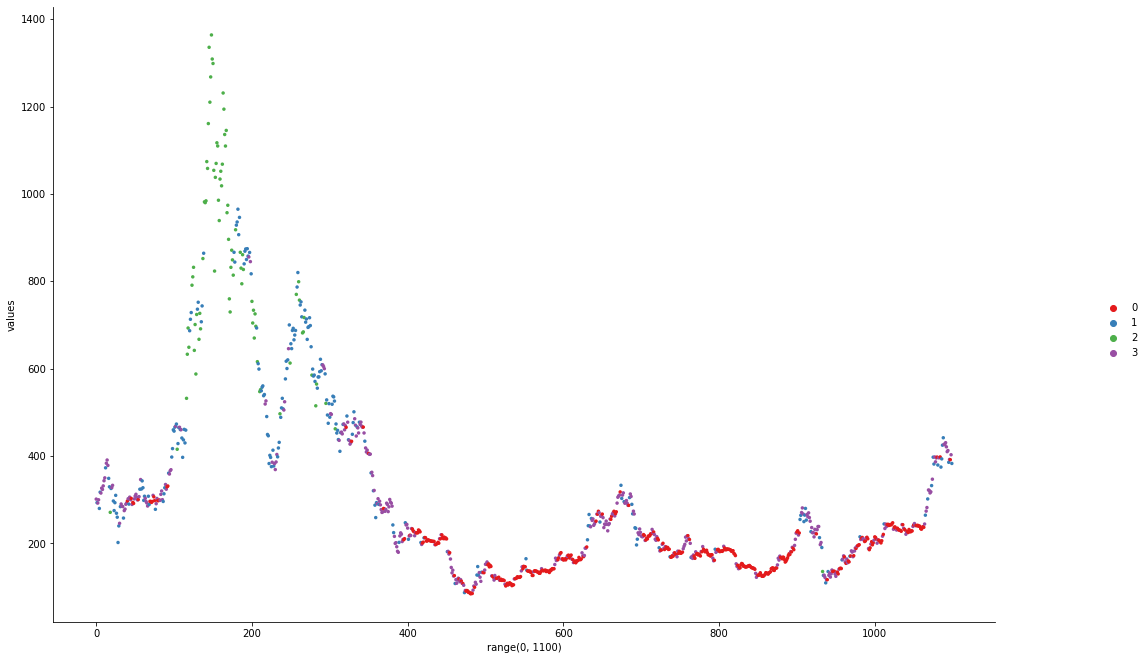

In [9]:
plot = sns.relplot(x=range(0, len(predictions)), y="values", data = df, hue=predictions, linewidth = 0, palette="Set1", s = 12);
plot.fig.set_size_inches(18,10)

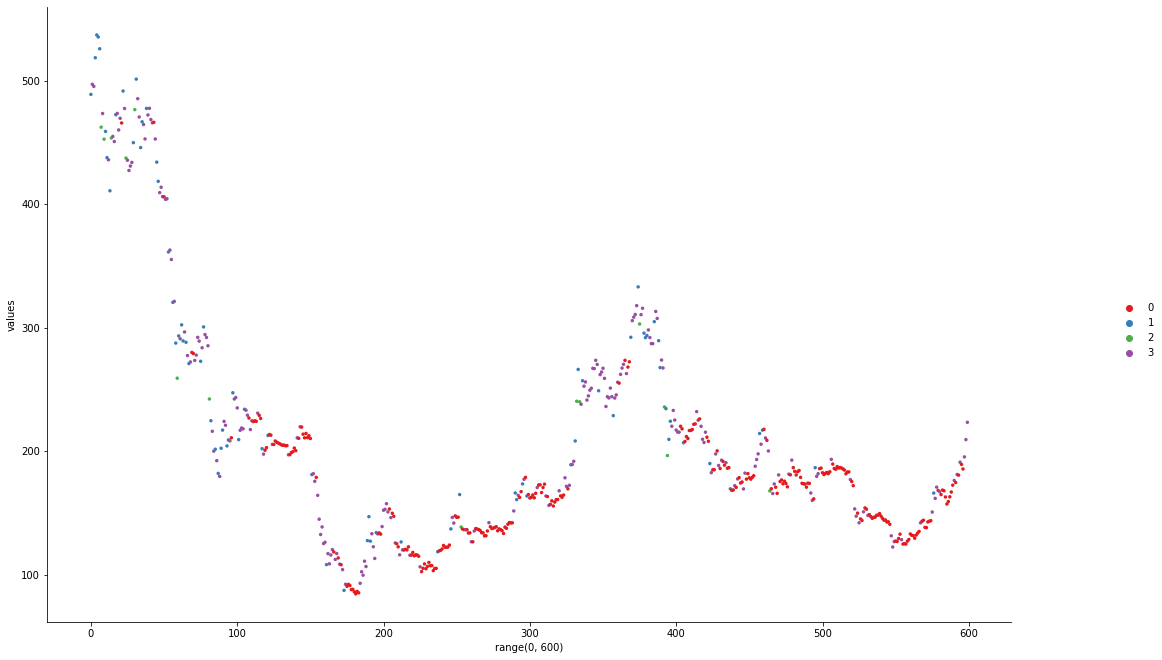

In [14]:
tdf = df.iloc[300:900, :]
training_obs = obs[300:900]
model = hmm.GaussianHMM(n_components = regimes, covariance_type="full", n_iter = 75);
model.fit(training_obs)
training_predictions = model.predict(training_obs)
plot = sns.relplot(x=range(0, len(training)), y="values", data = tdf, hue=training_predictions, linewidth = 0, palette="Set1", s = 12);
plot.fig.set_size_inches(18,10)

In [19]:
regime_count = {}
regime_returns = {}
regime_volatility = {}

for i in range(0, regimes):
    regime_returns[i] = 0
    regime_volatility[i] = 0
    regime_count[i] = 0
    
for i in range(0, len(training_predictions)):
    regime_count[training_predictions[i]] += 1
    
for i in range(0, len(training_obs)):
    regime_returns[training_predictions[i]] += training_obs[i][0]
    regime_volatility[training_predictions[i]] += training_obs[i][1]

for i in range(0, regimes):
    regime_returns[i] = regime_returns[i] / regime_count[i]
    regime_volatility[i] = regime_volatility[i] / regime_count[i]

In [22]:
for i in range(0, regimes):
    print("Regime " + str(i) + " return is " + str(regime_returns[i]))
    print("Regime " + str(i) + " volatility is " + str(regime_volatility[i]))

Regime 0 return is -0.0005391122425350869
Regime 0 volatility is 1.4587362201497074
Regime 1 return is 0.010781765301913984
Regime 1 volatility is 56.034175331178034
Regime 2 return is -0.06916362081842699
Regime 2 volatility is 210.48870900831542
Regime 3 return is 7.826718667233162e-05
Regime 3 volatility is 10.60133454574499


In [23]:
model.transmat_

array([[7.22484977e-01, 6.03604578e-02, 1.84327500e-28, 2.17154565e-01],
       [7.62223662e-02, 2.62595327e-01, 1.09870957e-01, 5.51311349e-01],
       [9.51506749e-02, 5.45655600e-01, 1.86863011e-24, 3.59193725e-01],
       [3.27666366e-01, 1.84945484e-01, 2.71736811e-02, 4.60214468e-01]])

In [119]:
curr = training[:-100]
value = 100
position = 0
history = []
positions = []
size = len(test)
for i in range(0, size):
    if i != 0 and position == 1:
        value *= (0.999 + test[i][0])
    elif i != 0 and position == -1:
        value *= (0.999 - test[i][0])
    curr.append(test[i])
    forecast = model.predict(curr)[-1]
    if forecast == 0:
        position = 1
    elif forecast == 1:
        position = -1
    elif forecast == 2:
        position = 1
    elif forecast == 3:
        position = 0
    history.append(value)
    positions.append(position)

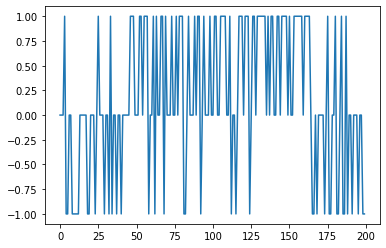

In [120]:
plt.plot(positions)

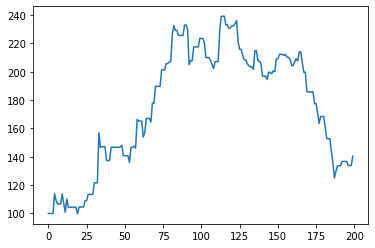

In [121]:
plt.plot(history)

In [122]:
data = list(np.asarray(get_all_binance("ETHUSDT", "5m", save = True)['close'], dtype= np.float))

All caught up..!


380.32